In [2]:
import sys
sys.path.append('../../code')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
from scipy.special import gamma

In [21]:
alpha = 1.8


# Backend tensorflow.compat.v1
def fpde(x, y, int_mat):
    """du/dt + (D_{0+}^alpha + D_{1-}^alpha) u(x) = f(x)"""
    if isinstance(int_mat, (list, tuple)) and len(int_mat) == 3:
        int_mat = tf.SparseTensor(*int_mat)
        lhs = -tf.sparse_tensor_dense_matmul(int_mat, y)
    else:
        lhs = -tf.matmul(int_mat, y)
    dy_t = tf.gradients(y, x)[0][:, 1:2]
    x, t = x[:, :-1], x[:, -1:]
    rhs = -dy_t - tf.exp(-t) * (
        x ** 3 * (1 - x) ** 3
        + gamma(4) / gamma(4 - alpha) * (x ** (3 - alpha) + (1 - x) ** (3 - alpha))
        - 3 * gamma(5) / gamma(5 - alpha) * (x ** (4 - alpha) + (1 - x) ** (4 - alpha))
        + 3 * gamma(6) / gamma(6 - alpha) * (x ** (5 - alpha) + (1 - x) ** (5 - alpha))
        - gamma(7) / gamma(7 - alpha) * (x ** (6 - alpha) + (1 - x) ** (6 - alpha))
    )
    return lhs - rhs[: tf.size(lhs)]

In [32]:
def func(x):
    x, t = x[:, :-1], x[:, -1:]
    return np.exp(-t) * x ** 3 * (1 - x) ** 3


geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

# Static auxiliary points
data = dde.data.TimeFPDE(
    geomtime,
    fpde,
    alpha,
    [bc, ic],
    [52],
    meshtype="static",
    num_domain=400,
    solution=func,
)

# Dynamic auxiliary points
'''data = dde.data.TimeFPDE(
     geomtime,
     fpde,
     alpha,
     [bc, ic],
     [100],
     num_domain=20,
     num_boundary=1,
     num_initial=1,
     solution=func,
     num_test=50,
 )'''

'data = dde.data.TimeFPDE(\n     geomtime,\n     fpde,\n     alpha,\n     [bc, ic],\n     [100],\n     num_domain=20,\n     num_boundary=1,\n     num_initial=1,\n     solution=func,\n     num_test=50,\n )'

Compiling model...
'compile' took 0.000592 s



Training model...



c:\Users\Marco\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Step      Train loss                        Test loss                         Test metric
0         [4.79e+01, 0.00e+00, 5.14e-19]    [4.79e+01, 0.00e+00, 0.00e+00]    []  
1000      [3.86e-02, 0.00e+00, 5.14e-19]    [3.86e-02, 0.00e+00, 0.00e+00]    []  
2000      [2.07e-02, 0.00e+00, 5.14e-19]    [2.07e-02, 0.00e+00, 0.00e+00]    []  
3000      [1.23e-02, 0.00e+00, 5.14e-19]    [1.23e-02, 0.00e+00, 0.00e+00]    []  
4000      [7.11e-03, 0.00e+00, 5.14e-19]    [7.11e-03, 0.00e+00, 0.00e+00]    []  
5000      [3.98e-03, 0.00e+00, 5.14e-19]    [3.98e-03, 0.00e+00, 0.00e+00]    []  
6000      [2.28e-03, 0.00e+00, 5.14e-19]    [2.28e-03, 0.00e+00, 0.00e+00]    []  
7000      [1.42e-03, 0.00e+00, 5.14e-19]    [1.42e-03, 0.00e+00, 0.00e+00]    []  
8000      [9.71e-04, 0.00e+00, 5.14e-19]    [9.71e-04, 0.00e+00, 0.00e+00]    []  
9000      [6.95e-04, 0.00e+00, 5.14e-19]    [6.95e-04, 0.00e+00, 0.00e+00]    []  

Best model at step 9000:
  train loss: 6.95e-04
  test loss: 6.95e-04
  test me

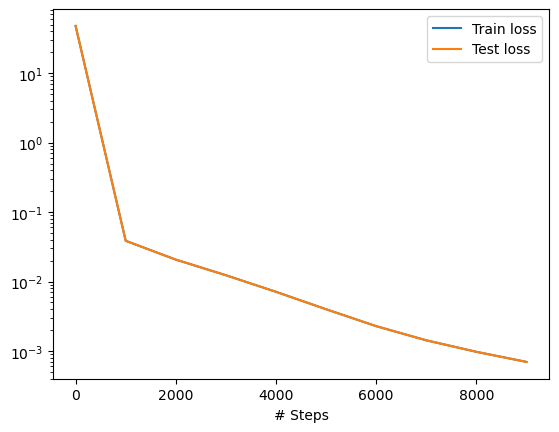

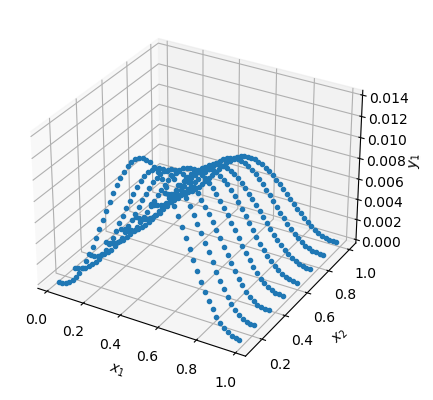

In [33]:
#net = dde.nn.FNN([2] + [100] + [1], "tanh", "Glorot normal")

M =100
layer_size = [1] + [M]  +  [1]

activation = ["random_sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)
net.apply_output_transform(
    lambda x, y: x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * y
    + x[:, 0:1] ** 3 * (1 - x[:, 0:1]) ** 3
)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=9000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

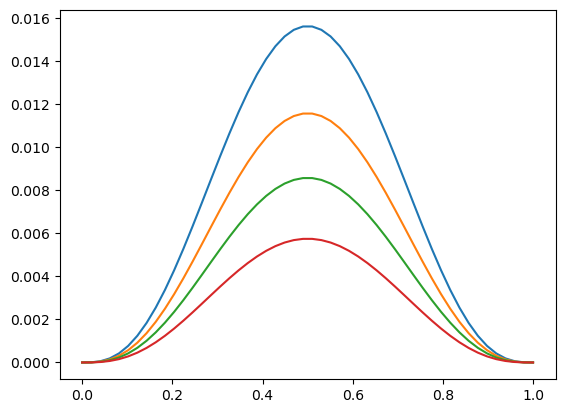

In [16]:
def p(x,t):
    return np.exp(-t)*(x**3 * (1-x)**3)

xx = np.linspace(0,1)
for t in [0, 0.3, 0.6, 1]:
    plt.plot(xx, p(xx, t))